In [1]:
%pylab inline
#http://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Conv1D, Dropout, ReLU, Flatten, Input, BatchNormalization, Reshape, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import sigmoid, tanh
from keras.losses import binary_crossentropy, mse
from keras.optimizers import SGD, Adam

from keras.utils import to_categorical
from keras.datasets import mnist


import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


C:\Users\cossa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cossa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cossa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cossa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [97]:
tf.__version__

'1.14.0'

In [31]:
#function for fingerprints

# General
# Generate FingerPrint of a program ! Not human !!!! 
import pickle
from collections import defaultdict

import pandas as pd
import numpy as np

from scipy.signal import savgol_filter
from scipy import interpolate
from scipy.optimize import least_squares
from scipy import integrate

flat_list= lambda x: [ g for f in x for g in f ]
double_list= lambda x: [[g] for g in x]
split_n= lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]

class Analyser:
    def __init__(self, name, method='moda', npoints= 100):
        self.name= name
        if type(name) == str:
            self.data= self.load_data(name)
        else:
            self.data= name
        if method == 'moda':
            self.df, _ = self.moda_df()
        elif method == 'interpolation':
            self.df = self.interpolated_df(npoints)

    def load_data(self, name):
        """
            load data from file
        """
        with open(name, 'rb+') as f:
            data= pickle.load(f)
        return data

    def moda_df(self, verbose=False):
        """
            Resume multiple runs in one dataframe

            Remove outsamples using median split
            Average results and calculate standard deviation
        """
        # find the moda shape
        count_shapes= defaultdict(lambda:0)
        for r in self.data['data']:
            count_shapes[np.shape(r)]+=1
        moda_shape= max(count_shapes,key=count_shapes.get)
        data_moda= [d for d in self.data['data'] if np.shape(d) == moda_shape]

        if verbose:
            print("Moda shape counts {:.2f}%".format(count_shapes[moda_shape]/len(count_shapes.values())*100))
            print(count_shapes[moda_shape], sum(count_shapes.values()))

        el= int(count_shapes[moda_shape]*0.3)//2
        data_moda= np.asarray(data_moda)
        med_avg= np.sort(data_moda,axis=0)

        if el != 0:
            med_avg= med_avg[el:-el]

        def diff(x):
            x= np.concatenate( (x[:,0:1,:] , x[:,1:,:]-x[:,:-1,:]), axis=1 )/self.data['sample_period']
            return x

        med_avg= diff(med_avg)
        std_avg= med_avg.std(axis=0)
        med_avg= med_avg.mean(axis=0)

        # create the dataframe
        med_avg= pd.DataFrame(med_avg, columns=flat_list(self.data['to_monitor']))
        std_avg= pd.DataFrame(std_avg, columns=flat_list(self.data['to_monitor']))

        # quality of the samples (experimental)
        if verbose:
            q= std_avg.values/med_avg.values
            print("AVG 68% samples error", np.nanmean(q)*100)
            print("AVG 99% samples error", np.nanmean(3*q)*100)

            print("MAX 68% samples error", np.nanmax(q)*100)
            print("MAX 99% samples error", np.nanmax(3*q)*100)

        return med_avg, std_avg

    def interpolated_df(self, npoints= 100):
        new_data= []
        for r in self.data['data']:
            x= np.asarray(r)
            new_c= []
            for c in range(x.shape[1]):
                fserie= np.trim_zeros(x[:,c])
                if len(fserie) < 4:
                    if len(fserie) >= 1: fserie= np.hstack((fserie,[fserie[-1]]*(4-len(fserie))))
                    else: fserie= np.hstack((fserie,[0]*(4-len(fserie))))
                x0, y0= np.linspace(0,1,len(fserie)), fserie
                tck = interpolate.splrep(x0, y0, s=0)
                x1 = np.linspace(0,1,npoints)
                y1 = interpolate.splev(x1, tck, der=0)
                new_c.append(list(y1))
            new_data.append(new_c)

        new_data= np.asarray(new_data)

        el= int(len(self.data['data'])*0.3)//2
        med_avg= np.sort(new_data,axis=0)
        std_avg= np.sort(new_data,axis=0)
        if el != 0:
            med_avg= med_avg[el:-el].mean(axis=0)
            std_avg= std_avg[el:-el].std(axis=0)
        else:
            med_avg= med_avg.mean(axis=0)
            std_avg= std_avg.mean(axis=0)

        med_avg= pd.DataFrame(med_avg, columns=flat_list(self.data['to_monitor']))

        count_shapes= defaultdict(lambda:0)
        for r in self.data['data']:
            count_shapes[np.shape(r)]+=1
        moda_shape= max(count_shapes,key=count_shapes.get)

        def diff(df):
            x= df.values
            x= np.row_stack( (x[0,:] , x[1:,:]-x[:-1,:]) )/(self.data['sample_period']*moda_shape[0]/npoints)
            return pd.DataFrame(x, columns=df.columns)

        med_avg= diff(med_avg)
        for c in med_avg.columns:
            med_avg[c]= savgol_filter(med_avg[c].values,11,3)

        return med_avg

    def interpolate(self, feature, npoints=100, filter_signal=True, proportional=False):
        f_series= np.trim_zeros(self.df[feature].values)
        if f_series.shape[0] < 4:
            raise Exception("Cant interpolate")

        x0, y0= np.linspace(0,1,len(f_series)), f_series
        tck = interpolate.splrep(x0, y0, s=0)
        x1 = np.linspace(0,1,npoints)
        y1 = interpolate.splev(x1, tck, der=0)

        if filter_signal: y1= savgol_filter(y1,11,3)

        if proportional:
            I= integrate.simps(y0)
            Ia= integrate.simps(y1)
            y1*=I/Ia

        return x1, y1

    @staticmethod
    def homography_tranform(x0, y0, x1, y1):
        """
            find homography matrix and tranform y0 to y1
        """
        A = []
        for i in range(0, len(x0)):
            x, y = x0[i], y0[i]
            u, v = x1[i], y1[i]
            A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
            A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
        A = np.asarray(A)
        U, S, Vh = np.linalg.svd(A)
        L = Vh[-1,:] / Vh[-1,-1]
        R = L.reshape(3, 3)

        h= np.ones(y0.shape)
        P1= np.hstack( [x0,y0,h] ).reshape((-1,3),order='F')
        P2= np.hstack( [x1,y1,h] ).reshape((-1,3),order='F')

        t_p= R.dot(P1.T).T
        return t_p, np.mean( np.abs(t_p-P2) )

    @staticmethod
    def scale_translation_matrix(x0,y0,x1,y1):
        """
            find the scale and translation matrix from (x0,y0) to (x1,y1)
        """
        def scf(c,x,y):
            return c[0]*x+c[1]-y

        Rx= least_squares(scf,np.ones(2), args=(x0,x1), loss='soft_l1').x
        Ry= least_squares(scf,np.ones(2), args=(y0,y1), loss='soft_l1').x

        xt= x0*Rx[0]+Rx[1]
        yt= y0*Ry[0]+Ry[1]
        t_p= np.hstack( [xt,yt] ).reshape((-1,2),order='F')
        P2= np.hstack( [x1,y1] ).reshape((-1,2),order='F')

        return t_p, np.sum( np.abs(t_p-P2) )

    @staticmethod
    def compare(a1, a2, feature='PERF_COUNT_HW_INSTRUCTIONS', npoints_=100):
        x0, y0= a1.interpolate(feature=feature, npoints= npoints_)
        x1, y1= a2.interpolate(feature=feature, npoints= npoints_)
        yt, err= Analyser.scale_translation_matrix(x0, y0, x1, y1)
        return yt, err(venv)
    
    

In [32]:
#parameters
number_of_points = 100
dim_in = 100


In [4]:
#LOAD DATASET FREQ A


suceed = 0
fail = 0
name = "Downloads/fingerprint/"
import os, tqdm

all_shapes_A= []
newname = "Downloads/data/"

names = [newname + "hpc_belgica/v2/", newname + "hpc_belgica/v3/", newname + "hpc_brasil/v2/", newname + "pc_lab/v3/", "Downloads/fingerprint/" ]
names= [name]
for x in range (len(names)) : 
    for f in tqdm.tqdm_notebook(os.listdir(names[x])):
        a= Analyser( os.path.join(names[x], f) )
        a.df['input_size']= a.df['PERF_COUNT_HW_INSTRUCTIONS']/a.df['MEM_UOPS_RETIRED:ALL_STORES'] 
        a.df= a.df.dropna()
        try:
            _, y0= a.interpolate(feature='input_size', npoints  = number_of_points)
            all_shapes_A.append(y0)
            suceed = suceed +1
        except:
            fail = fail +1 
            pass
    
    
print ('suceed', suceed)
print ('fail',fail)



C:\Users\cossa\anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



suceed 90
fail 60


In [ ]:
#LOAD DATASET FREQ B


suceed = 0
fail = 0
name = "Downloads/fingerprint/"
import os, tqdm

all_shapes_B= []
newname = "Downloads/data/"

names = [newname + "hpc_belgica/v2/", newname + "hpc_belgica/v3/", newname + "hpc_brasil/v2/", newname + "pc_lab/v3/", "Downloads/fingerprint/" ]

for x in range (len(names)) : 
    for f in tqdm.tqdm_notebook(os.listdir(names[x])):
        a= Analyser( os.path.join(names[x], f) )
        a.df['input_size']= a.df['PERF_COUNT_HW_INSTRUCTIONS']/a.df['MEM_UOPS_RETIRED:ALL_STORES'] 
        a.df= a.df.dropna()
        try:
            _, y0= a.interpolate(feature='input_size', npoints  = number_of_points)
            all_shapes_B.append(y0)
            suceed = suceed +1
        except:
            fail = fail +1 
            pass
    
    
print ('suceed', suceed)
print ('fail',fail)



In [81]:
#maybe use the FingerPrint Gan to generate more data of a specific frequency to increase the database



import pickle, os
import pandas as pd
data_A=[]
data_B=[]
path = "Downloads/data/pc_lab/data_freq/"
suceed = 0
fail = 0
for f in os.listdir(path):
    with open(path+f, "rb+") as f:
        data= pickle.load(f)
        #print(data.keys())
        for thr in data["data"]: # loop for the threads
            #print(thr["thr"])
            for freq in thr["threads"]: # loop for the freqs
               # print(freq["freq"])
                aux= {k:data[k] for k in data if k != "data"}
                aux["data"]= freq["data"]
                x= Analyser(aux)
                x.df['input_size']= x.df['PERF_COUNT_HW_INSTRUCTIONS']/x.df['MEM_UOPS_RETIRED:ALL_STORES']
                x.df= x.df.dropna()
                try:
                    _, y0= x.interpolate(feature='input_size', npoints  = number_of_points)
                    suceed = suceed +1
                    if freq["freq"] == "3000000":
                        data_A.append(y0)
                        print('data_A')
                    if freq["freq"] == "1200000":
                        data_B.append(y0)
                        print('data_B')
                except:
                    fail = fail +1 
                    pass
print ('suceed', suceed)
print ('fail',fail)


data_B
data_A
data_B
data_A
data_B
data_A
data_B
data_A
data_B
data_A
data_B
data_A
data_B
data_A
data_B
data_A
data_B
suceed 84
fail 106


In [58]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17397216682190225858
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1486228684
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6570444807689465521
physical_device_desc: "device: 0, name: GeForce GT 745M, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


(8, 100)
(9, 100)


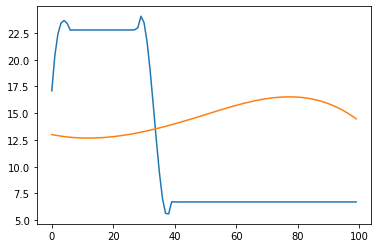

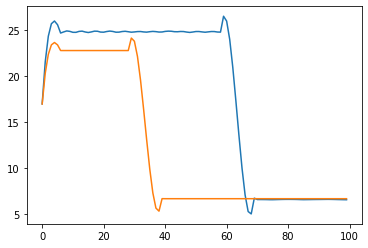

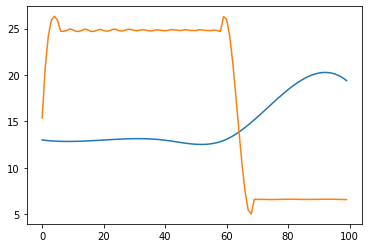

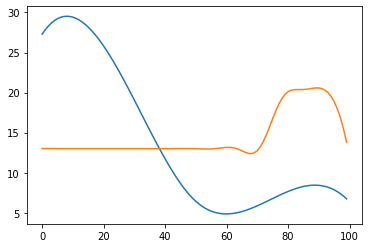

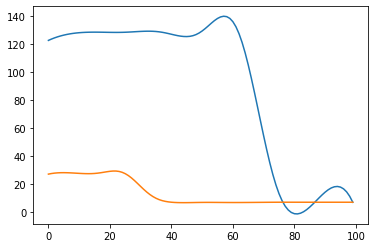

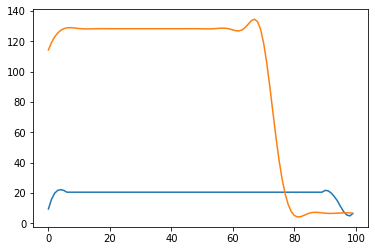

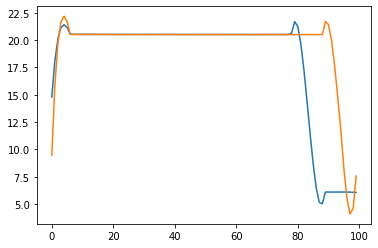

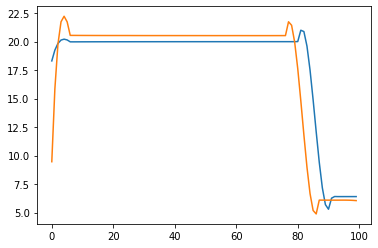

In [82]:
array_fingerprints_A = np.array(data_A)
array_fingerprints_B = np.array(data_B)

print (array_fingerprints_A.shape)
print (array_fingerprints_B.shape)


for x in range(len(array_fingerprints_A)):
    figure()
    plot(array_fingerprints_A[x])
    plot(array_fingerprints_B[x])
    
# for x in range(len(array_fingerprints_B)):
#     figure()
#         

In [83]:
# define the discriminator model
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(1, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

In [61]:
#define generator
def get_generator():
    g = Sequential()
    g.add(Dense(256,input_shape=(dim_in,)))
    g.add(LeakyReLU(alpha=0.2))
    g.add(BatchNormalization(momentum=0.8))
    #generator.add(Dense(512))
    g.add(Dense(512, activation = "tanh"))
    g.add(LeakyReLU(alpha=0.2))
    g.add(Dropout(0.3)) 
    g.add(Dense(1024))
    g.add(LeakyReLU(alpha=0.2))
    g.add(Dropout(0.3)) 
    g.add(Dense(number_of_points, activation = "relu")) #re
    g.compile(optimizer=Adam(lr=0.002, beta_1=0.5),loss=mse)
    return g

In [62]:
# define a composite model for updating generators by adversarial and cycle lossµ

def define_composite_model(g_model_1, d_model, g_model_2, number_of_points):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input((dim_in,))
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	print(input_gen)
	input_id = Input((dim_in,))
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, batch_sample, batch_size):
    idx= np.random.randint(low=0,high=batch_sample,size=batch_size)
    data_real= dataset[idx]
    yaux= np.zeros(batch_size) 
    #print(data_real.shape)
    #print(yaux.shape)
    return data_real, yaux

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, batch_size, dim_in):
    # generate fake instance
    noise = np.random.uniform(0, 1, size=[batch_size, dim_in])
    #print(noise.shape)
    data_gen= g_model.predict(noise)
    yaux= np.ones(batch_size) 
    #print(data_gen.shape)
    #print(yaux.shape)
    return data_gen, yaux

In [ ]:
'''# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
    
    '''


In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [84]:


# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA):
    
    
    
    
    #batch_sample = len(array_fingerprints_A) ---> maybe min of the two array
    batch_sample = 8
    batch_size = 2  #16 or 32
    print(batch_size)
    batch_count=batch_sample//batch_size
    print(batch_count)
    
    




    n_epochs, n_batch= 100, 1
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(array_fingerprints_A) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(array_fingerprints_A, batch_sample, batch_size)
        X_realB, y_realB = generate_real_samples(array_fingerprints_B, batch_sample, batch_size)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, batch_size, dim_in)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, batch_size, dim_in)
        # update fakes from pool
        #X_fakeA = update_image_pool(poolA, X_fakeA) #not needed -> used to learn faster but with graphs it's not needed
        #X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        
		# update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
		# update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        
		# update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
		# summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
        
		#if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
            
			#summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            
			# plot B->A translation
            
			#summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
            
		#if (i+1) % (bat_per_epo * 5) == 0:
            
			# save the models
			#save_models(i, g_model_AtoB, g_model_BtoA)

In [85]:
# load image data
#dataset = load_real_samples('horse2zebra_256.npz')
#print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
#image_shape = dataset[0].shape[1:]

# generator: A -> B
#g_model_AtoB = define_generator(number_of_points)
g_model_AtoB = get_generator()
g_model_BtoA = get_generator()

# discriminator: A -> [real/fake]
#d_model_A = define_discriminator(number_of_points)

D_in = Input(shape=[number_of_points])
d_model_A, d_out = get_discriminative(D_in)
d_model_B, d_out = get_discriminative(D_in)



# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, number_of_points)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, number_of_points)


# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA)

Tensor("input_42:0", shape=(?, 100), dtype=float32)
Tensor("input_44:0", shape=(?, 100), dtype=float32)
2
4
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)


C:\Users\cossa\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\cossa\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\cossa\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\cossa\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weigh

>1, dA[3.171,0.858] dB[1.091,0.774] g[1014.770,807.897]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>2, dA[0.000,1.254] dB[0.000,0.805] g[360.108,375.746]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>3, dA[0.000,1.432] dB[0.000,0.782] g[789.955,982.587]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>4, dA[0.000,1.571] dB[0.000,0.717] g[453.745,458.098]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>5, dA[0.000,1.781] dB[0.000,0.649] g[423.223,412.646]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>6, dA[0.000,2.085] dB[0.000,0.557] g[353.758,366.259]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>7, dA[0.000,2.098] dB[0.000,0.463] g[993.879,799.346]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>8, dA[0.000,1.139] dB[0.000,0.371] g[382.752,418.757]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 

>65, dA[0.000,0.000] dB[0.000,0.000] g[382.887,357.397]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>66, dA[0.000,0.000] dB[0.000,0.000] g[626.067,821.924]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>67, dA[0.000,0.000] dB[0.001,0.000] g[214.849,244.501]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>68, dA[0.000,0.000] dB[0.000,0.006] g[578.011,780.400]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>69, dA[0.000,0.000] dB[0.000,0.001] g[1221.377,1211.413]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>70, dA[0.000,0.000] dB[0.000,0.000] g[205.599,210.808]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>71, dA[0.000,0.000] dB[0.000,0.000] g[232.757,243.881]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>72, dA[0.000,0.000] dB[0.000,0.000] g[1209.184,1217.424]
(2, 100)
(2,)
(2, 100)
(2,)
(2

>128, dA[0.000,0.000] dB[0.000,0.000] g[732.452,535.266]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>129, dA[0.000,0.000] dB[0.000,0.001] g[1431.638,995.021]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>130, dA[0.000,0.000] dB[0.000,0.000] g[488.980,669.908]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>131, dA[0.000,0.000] dB[0.000,0.000] g[493.562,679.315]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>132, dA[0.000,0.000] dB[0.000,0.001] g[140.501,138.632]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>133, dA[0.000,0.000] dB[0.000,0.000] g[132.479,153.754]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>134, dA[0.000,0.000] dB[0.000,0.000] g[287.185,216.278]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>135, dA[0.000,0.000] dB[0.000,0.000] g[155.910,136.535]
(2, 100)
(2,)
(2, 100)
(2

>192, dA[0.000,0.000] dB[0.791,0.000] g[124.547,122.619]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>193, dA[0.000,0.000] dB[0.000,0.000] g[727.610,602.445]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>194, dA[0.000,0.000] dB[0.000,0.000] g[134.046,134.548]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>195, dA[0.000,0.000] dB[0.000,0.000] g[658.864,480.770]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>196, dA[0.000,0.000] dB[0.000,0.000] g[468.016,647.132]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>197, dA[0.000,0.000] dB[0.000,0.000] g[194.090,244.754]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>198, dA[0.000,0.000] dB[0.000,0.000] g[171.876,184.017]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>199, dA[0.000,0.000] dB[0.000,0.000] g[157.560,204.042]
(2, 100)
(2,)
(2, 100)
(2,

>255, dA[0.000,0.000] dB[0.000,0.003] g[132.463,135.606]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>256, dA[0.000,0.000] dB[0.000,0.001] g[129.069,134.990]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>257, dA[0.000,0.000] dB[0.000,0.002] g[674.765,496.565]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>258, dA[0.000,0.000] dB[0.000,0.000] g[103.399,108.487]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>259, dA[0.000,0.000] dB[0.000,0.003] g[114.724,128.125]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>260, dA[0.000,0.000] dB[0.000,0.001] g[1017.870,1009.398]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>261, dA[0.000,0.000] dB[0.000,0.000] g[672.826,501.411]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>262, dA[0.000,0.000] dB[0.000,0.000] g[131.369,208.281]
(2, 100)
(2,)
(2, 100)
(

>318, dA[0.000,0.000] dB[0.000,0.009] g[667.400,461.475]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>319, dA[0.000,0.000] dB[0.000,0.008] g[657.687,463.859]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>320, dA[0.000,0.000] dB[0.000,0.074] g[108.622,108.559]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>321, dA[0.000,0.000] dB[0.000,0.084] g[659.807,502.433]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>322, dA[0.000,0.000] dB[0.000,0.030] g[123.898,143.665]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>323, dA[0.000,0.000] dB[0.000,0.001] g[629.168,452.974]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>324, dA[0.000,0.000] dB[0.000,0.001] g[478.483,650.019]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>325, dA[0.000,0.000] dB[0.000,0.000] g[653.645,447.925]
(2, 100)
(2,)
(2, 100)
(2,

>381, dA[0.000,0.000] dB[0.000,0.000] g[107.384,110.829]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>382, dA[0.000,0.000] dB[0.000,0.000] g[100.388,100.405]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>383, dA[0.000,0.000] dB[0.000,0.000] g[93.681,94.956]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>384, dA[0.000,0.000] dB[0.000,0.000] g[652.596,451.473]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>385, dA[0.000,0.000] dB[0.000,0.000] g[157.730,119.819]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>386, dA[0.000,0.000] dB[0.000,0.000] g[674.190,518.470]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>387, dA[0.000,0.000] dB[0.008,0.000] g[441.265,609.230]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>388, dA[0.000,0.000] dB[0.000,0.000] g[646.500,416.784]
(2, 100)
(2,)
(2, 100)
(2,)


>445, dA[0.000,0.000] dB[0.000,0.000] g[101.441,126.723]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>446, dA[0.000,0.000] dB[0.000,0.000] g[127.689,110.405]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>447, dA[0.000,0.000] dB[0.000,0.000] g[108.471,118.092]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>448, dA[0.000,0.000] dB[0.035,0.000] g[441.734,644.592]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>449, dA[0.000,0.000] dB[0.000,0.000] g[116.621,178.160]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>450, dA[0.000,0.000] dB[0.000,0.000] g[112.237,105.192]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>451, dA[0.000,0.000] dB[0.000,0.000] g[644.364,435.836]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>452, dA[0.000,0.000] dB[0.000,0.000] g[400.219,593.065]
(2, 100)
(2,)
(2, 100)
(2,

>509, dA[0.000,0.000] dB[0.000,0.161] g[401.836,583.752]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>510, dA[0.000,0.000] dB[0.000,0.003] g[131.433,127.928]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>511, dA[0.000,0.000] dB[0.000,0.059] g[452.542,589.047]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>512, dA[0.000,9.123] dB[0.000,0.000] g[111.145,110.789]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>513, dA[0.000,0.000] dB[0.000,0.000] g[637.747,431.857]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>514, dA[2.393,0.000] dB[0.000,0.002] g[665.549,438.730]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>515, dA[3.117,0.000] dB[0.000,0.002] g[446.023,616.329]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>516, dA[0.000,0.000] dB[0.000,0.000] g[523.957,622.204]
(2, 100)
(2,)
(2, 100)
(2,

>572, dA[0.001,0.000] dB[0.000,0.000] g[629.208,452.674]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>573, dA[0.000,0.000] dB[0.000,0.000] g[620.253,441.278]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>574, dA[0.000,0.000] dB[0.016,0.000] g[126.658,100.895]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>575, dA[0.000,0.000] dB[0.028,0.000] g[670.174,532.635]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>576, dA[0.000,0.000] dB[0.066,0.000] g[404.064,597.864]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>577, dA[0.000,0.000] dB[0.150,0.000] g[930.791,933.029]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>578, dA[0.000,0.000] dB[0.000,0.000] g[108.649,118.623]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>579, dA[0.000,0.000] dB[0.008,0.000] g[397.116,576.207]
(2, 100)
(2,)
(2, 100)
(2,

(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>636, dA[0.000,0.000] dB[0.000,0.000] g[111.980,127.721]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>637, dA[0.000,0.000] dB[0.000,0.000] g[96.211,89.498]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>638, dA[0.000,0.000] dB[0.000,0.001] g[599.696,432.972]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>639, dA[0.000,0.000] dB[0.000,0.000] g[1644.371,1359.296]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>640, dA[0.000,0.000] dB[0.000,0.001] g[1384.132,952.568]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>641, dA[0.000,0.000] dB[0.000,0.000] g[208.291,187.797]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>642, dA[0.000,0.000] dB[0.000,0.000] g[95.450,160.648]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>643, dA[0.000,0.000] dB[0.000,0.000] g[599.40

>700, dA[0.000,0.000] dB[0.000,0.006] g[418.916,573.750]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>701, dA[0.000,0.000] dB[0.000,0.000] g[388.901,538.399]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>702, dA[0.000,0.000] dB[0.000,0.000] g[92.828,86.953]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>703, dA[0.000,0.000] dB[0.000,0.000] g[580.715,384.542]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>704, dA[0.000,0.000] dB[0.000,0.000] g[100.282,102.919]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>705, dA[0.000,0.000] dB[0.000,0.000] g[160.063,98.235]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>706, dA[0.000,0.000] dB[0.000,0.000] g[88.602,97.879]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>707, dA[0.000,0.000] dB[0.000,0.000] g[151.476,106.040]
(2, 100)
(2,)
(2, 100)
(2,)
(2,

(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>765, dA[0.000,0.000] dB[0.000,0.000] g[110.536,118.907]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>766, dA[0.000,0.000] dB[0.000,0.000] g[120.186,123.743]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>767, dA[0.009,0.000] dB[0.000,0.000] g[122.632,181.553]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>768, dA[0.000,0.000] dB[0.000,0.012] g[590.698,370.429]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>769, dA[0.002,0.000] dB[0.000,0.000] g[109.853,102.637]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>770, dA[1.151,0.000] dB[0.000,0.000] g[126.885,138.897]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>771, dA[0.000,0.000] dB[0.000,0.000] g[116.534,118.533]
(2, 100)
(2,)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
(2, 100)
(2, 100)
(2,)
>772, dA[0.000,0.000] dB[0.000,0.000] g[120.05

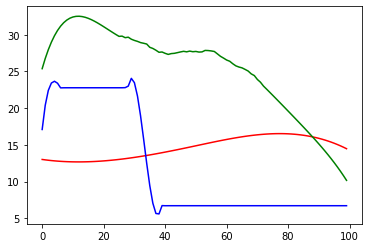

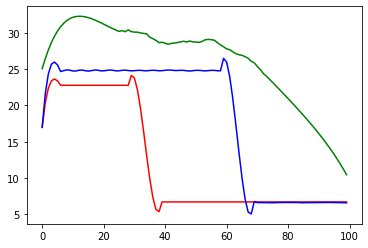

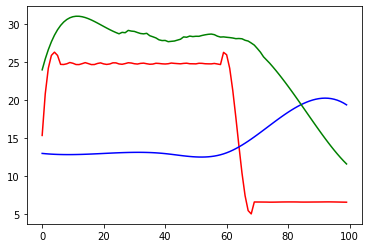

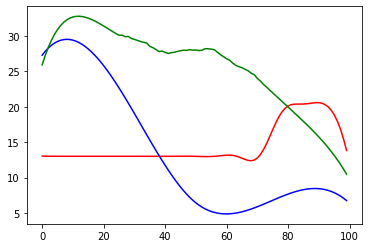

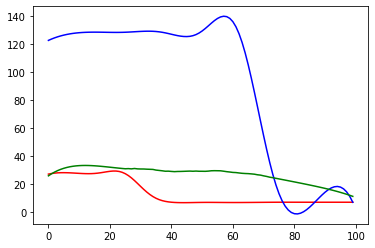

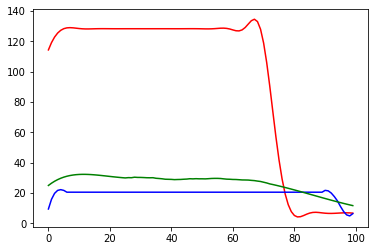

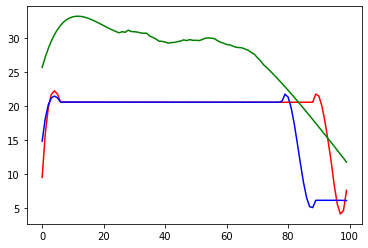

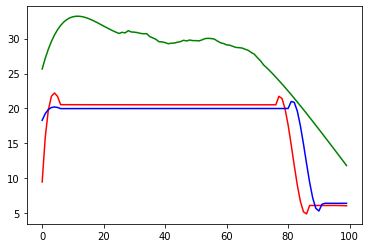

In [92]:
from scipy.signal import savgol_filter

data_gen= g_model_AtoB.predict(array_fingerprints_A)


for x in range (8):
    figure()
    plot(array_fingerprints_B[x], 'r')
    plot(array_fingerprints_A[x], 'b')
    plt.plot(savgol_filter(data_gen[x], 51, 4), 'g')
